<a href="https://colab.research.google.com/github/Nathan-Levy/Traffic-Flow-Prediction-in-Urban-Areas/blob/main/Final_Downtown_LA_Traffic_Prediction_I110_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.callbacks import LambdaCallback



In [ ]:
controller_data_test = pd.read_csv('Combined flows test.csv')
controller_data_test.dropna(how='all', inplace=True)

controller_data_train = pd.read_csv('Combined flows train.csv')
controller_data_train.dropna(how='all', inplace=True)

In [ ]:
controller_data_train["5 Minutes"] = pd.to_datetime(controller_data_train["5 Minutes"])
controller_data_train.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow_train = controller_data_train[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]

controller_data_test["5 Minutes"] = pd.to_datetime(controller_data_test["5 Minutes"])
controller_data_test.set_index("5 Minutes", inplace=True)

# Keep only the relevant column
time_flow_test = controller_data_test[['MADOR Flow (Veh/5 Minutes)', 'THIRD Flow (Veh/5 Minutes)', '11TH Flow (Veh/5 Minutes)', 'ADAMS Flow (Veh/5 Minutes)', 'KING BLVD Flow (Veh/5 Minutes)']]

print(time_flow_test)

                     MADOR Flow (Veh/5 Minutes)  THIRD Flow (Veh/5 Minutes)  \
5 Minutes                                                                     
2018-06-04 00:00:00                         116                         179   
2018-06-04 00:05:00                         119                         168   
2018-06-04 00:10:00                          88                         141   
2018-06-04 00:15:00                          81                         130   
2018-06-04 00:20:00                          84                         166   
...                                         ...                         ...   
2018-07-01 23:35:00                         153                         143   
2018-07-01 23:40:00                         152                         139   
2018-07-01 23:45:00                         139                         136   
2018-07-01 23:50:00                         149                         132   
2018-07-01 23:55:00                         136     

In [ ]:
# Normalise
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
flow_train_scaled = scaler.fit_transform(time_flow_train)
flow_test_scaled = scaler.transform(time_flow_test)

In [ ]:
# Train and validation split
flow_train, flow_test, = flow_train_scaled, flow_test_scaled

In [ ]:
def create_dataset(dataset, look_back):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), :])
        y.append(dataset[i + look_back, :])
    return np.array(X), np.array(y)

look_back = 12
X_train, y_train = create_dataset(flow_train, look_back)
X_test, y_test = create_dataset(flow_test, look_back)


# [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [ ]:
from keras import layers

class StoreWeightsCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.weights_history = []  # List to store weights after each epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_weights = {}  # Dictionary to store weights for this epoch
        for layer in self.model.layers:
            if hasattr(layer, 'weights') and layer.weights:
                epoch_weights[layer.name] = [w.numpy() for w in layer.weights]

        self.weights_history.append(epoch_weights)

input_layer = keras.layers.Input(shape=(look_back, 5))
encoded = keras.layers.LSTM(64, activation='tanh', return_sequences=True)(input_layer)
encoded = keras.layers.LSTM(32, activation='tanh', return_sequences=False)(encoded)

# Decoder
decoded = keras.layers.RepeatVector(look_back)(encoded)
decoded = keras.layers.LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = keras.layers.TimeDistributed(layers.Dense(5, activation='linear'))(decoded)

# Autoencoder Model
autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded)

# Compile the autoencoder
optimizer = keras.optimizers.Adam(clipnorm=1.0, learning_rate=0.0005)
autoencoder.compile(optimizer=optimizer, loss='mse')

autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 12, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 12, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector_3 (RepeatVector)       │ (None, 12, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 12, 64)              │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 12, 5)               │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 55,493 (216.77 KB)

 Trainable params: 55,493 (216.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the autoencoder
store_weights = StoreWeightsCallback()

train = autoencoder.fit(X_train, X_train, epochs=80, batch_size=16, validation_data=[X_test, X_test], callbacks = [store_weights])

Epoch 1/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0269 - val_loss: 0.0039
Epoch 2/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 3/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 4/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 5/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 6/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 7/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 8/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/80
1134/1134 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 12

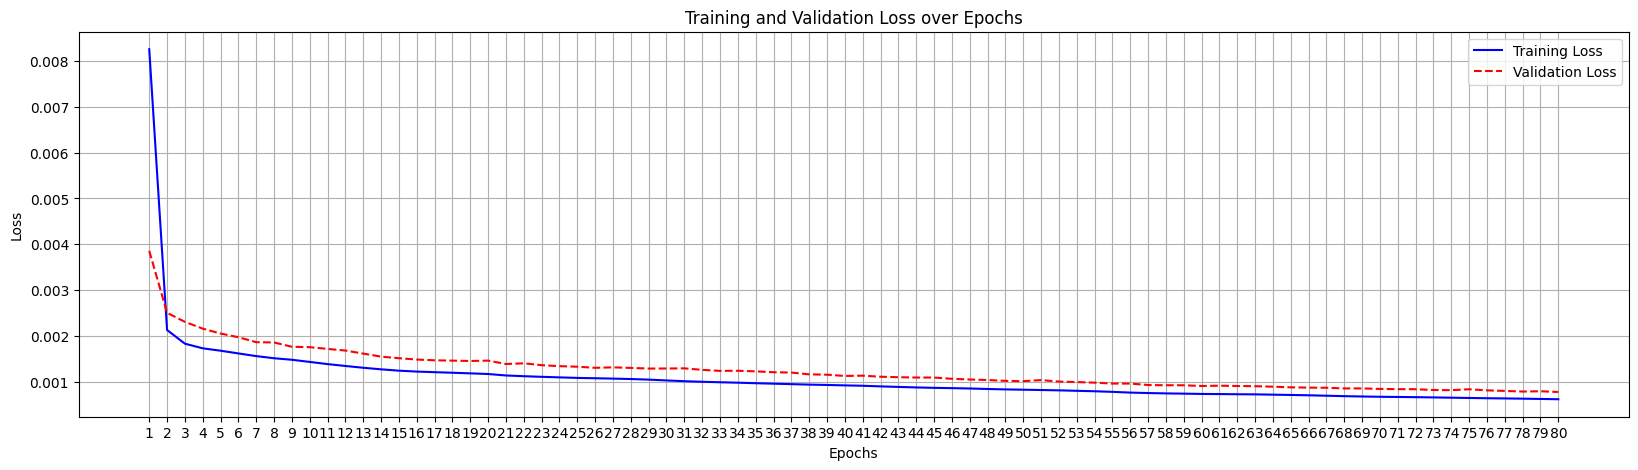

In [ ]:
# Function to plot loss over epochs
def plot_loss(history):
    plt.figure(figsize=(20, 5))
    epochs = range(1, len(history.history['loss']) + 1)  # Start from 1 instead of 0
    plt.plot(epochs, history.history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', color='red', linestyle='dashed')
    plt.xticks(epochs)  # This ensures every epoch is labeled
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(train)

In [ ]:
len(store_weights.weights_history)

80

In [ ]:
# Extract the encoder model
encoder = keras.models.Model(inputs=input_layer, outputs=encoded)

# Generate the encoded features
encoded_features = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
# Define the prediction model
prediction_model = keras.models.Sequential()
prediction_model.add(keras.layers.Dense(16, activation='relu', input_dim=encoded_features.shape[1]))
prediction_model.add(keras.layers.Dense(8, activation='relu'))
prediction_model.add(keras.layers.Dense(5, activation='linear'))

# Compile the prediction model
prediction_model.compile(optimizer='adam', loss='mse')

# Train the prediction model
prediction_model.fit(encoded_features, y_train, epochs=20, validation_data=(encoded_features_test, y_test))

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


567/567 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0318 - val_loss: 0.0055
Epoch 2/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0041 - val_loss: 0.0045
Epoch 3/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 4/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 5/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 6/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 7/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 8/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 9/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 10/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 11/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 12/20
567/567 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.

In [ ]:
# Use the prediction model to make predictions
y_pred = prediction_model.predict(encoded_features_test)

252/252 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
y_pred

array([[0.10113463, 0.15509151, 0.17716452, 0.12946214, 0.13407682],
       [0.09480281, 0.15030172, 0.17834735, 0.12872052, 0.13630483],
       [0.09142338, 0.13902378, 0.17274138, 0.12406215, 0.1292106 ],
       ...,
       [0.20741649, 0.2796582 , 0.42391956, 0.37974906, 0.31156418],
       [0.18998593, 0.2650766 , 0.4111215 , 0.36375526, 0.29891962],
       [0.17843105, 0.2468397 , 0.3908278 , 0.34749964, 0.28183448]],
      dtype=float32)

In [ ]:
# Inverse transform the predictions to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

In [ ]:
y_pred_rescaled

array([[ 61.388718, 110.13843 , 216.14114 , 133.34601 , 171.74721 ],
       [ 57.545307, 108.126724, 216.9833  , 132.58214 , 173.98636 ],
       [ 55.49399 , 103.389984, 212.99187 , 127.78401 , 166.85666 ],
       ...,
       [125.90181 , 162.45645 , 391.83075 , 391.14154 , 350.12198 ],
       [115.32146 , 156.33218 , 382.7185  , 374.6679  , 337.4142  ],
       [108.30765 , 148.67268 , 368.2694  , 357.92462 , 320.24365 ]],
      dtype=float32)

In [ ]:
import numpy as np

# Define evaluation metric functions
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_relative_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

# Function to evaluate model performance
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mre = mean_relative_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Relative Error (MRE): {mre:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Example Usage:
# Replace y_test and y_pred with actual test labels and predictions
# y_test = np.array([...])  # Actual traffic flow values
# y_pred = np.array([...])  # Predicted traffic flow values
evaluate_model(np.array(y_test_rescaled), np.array(y_pred_rescaled))


Mean Absolute Error (MAE): 29.9205
Mean Relative Error (MRE): 8.8990%
Root Mean Squared Error (RMSE): 41.2777


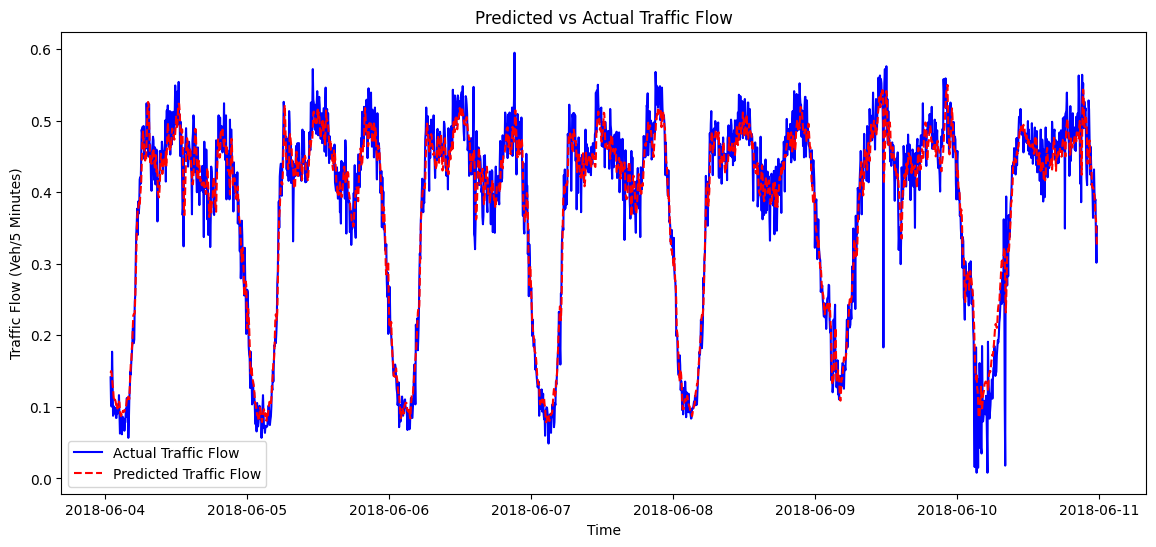

In [ ]:
# timestamps from validation set.
timestamps = time_flow_test.index[-len(y_test):]


# 287 timestamps in 1 day


plt.figure(figsize=(14, 6))
plt.plot(timestamps[:2000], y_test[:2000, -1], label='Actual Traffic Flow', color='blue')
plt.plot(timestamps[:2000], y_pred[:2000, -1], label='Predicted Traffic Flow', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Traffic Flow (Veh/5 Minutes)')
plt.title('Predicted vs Actual Traffic Flow')
plt.legend()
plt.show()
